# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mpl_defaults
from mpl_defaults import autoscale_y
import matplotlib as mpl
import matplotlib.transforms as transform
import scipy
import normal_He3_params as he3
import seaborn as sns
idx = pd.IndexSlice
from numpy.fft import fft 

# plt.style.use('dark_background')
%matplotlib widget

import cupy as cp

In [2]:
# %%html
# <style>
# .cell-output-ipywidget-background {
#    background-color: transparent !important;
# }
# .jp-OutputArea-output {
#    background-color: transparent;
# }  
# </style>



In [3]:
def d2dx2_cuda(num, dx):
    mat = cp.zeros((num+1, num+1))
    for i in range(num):
        mat[i, i] = -2
        try:
            mat[i, i-1] = 1
            mat[i, i+1] = 1
        except:pass
    return mat[0:num, 0:num]/dx**2

def ddx_cuda(num, dx):
    mat = cp.zeros((num+1, num+1))
    for i in range(num):
        try:
            mat[i, i-1] = -1
            mat[i, i+1] = 1
        except:pass
    return mat[0:num, 0:num]/dx



def d2dx2_periodic_cuda(num, dx):
    mat = cp.zeros((num, num))
    for i in range(num):
        mat[i,i]=-2
        try:
            mat[i, i-1]=1
            mat[i, i+1]=1
        except: pass
        return mat/dx**2
    
def ddx_periodic_cuda(num, dx):
    mat = cp.zeros((num, num))
    for i in range(num):
        try:
            mat[i, i-1] = -1
            mat[i, i+1] = 1
        except:pass
    return mat/dx

In [4]:

def psi(vecs, En, x):
    df= pd.concat([component_df(vecs, En, i, x) for i in np.arange(4)], axis = 1).T.sort_index().T
    return df

def component_df(vecs:np.array, En, component:int, x:np.array) -> pd.DataFrame:
    start = component*len(En)//4
    stop = (component+1)*len(En)//4

    pos_E = En[En>=0]
    neg_E = En[En<0]


    # particle_high_idx = np.where(En == pos_E[-1])[0][0]
    # hole_high_idx = np.where(En == neg_E[0])[0][0]

    # data = vecs[start:stop, hole_high_idx:particle_high_idx+1]
    data = vecs[start:stop, :]

    En_index = np.concatenate( [
        np.flip(np.arange(len(neg_E))*-1)-1,
        np.arange(len(pos_E))+1,
        ])
    df = pd.DataFrame(
        data, 
        index = x,
        columns = pd.MultiIndex.from_product([
            En_index,
            [f'c_{component}'],
        ])
    )

    df.columns.rename('En', level = 0, inplace = True)
    df.columns.rename(f'c_i', level = 1, inplace = True)
    df.index.rename('x', inplace = True)
    return df


def gap_spatial_perp(z, l = 10, strech = 1):
    # return cp.asarray(np.where(z<l/2, np.tanh(strech*z), np.tanh(strech*(z-l))*-1))
    return cp.where(z<l/2, np.tanh(strech*z), np.tanh(strech*(z-l))*-1)
    # if z < l/2: return np.tanh(z)
    # else: return np.tanh(z-10)*-1

def pandas_fft(data) -> pd.Series:
    return pd.DataFrame(
        data = fft(data),
        index = data.index
    )

def psi(vecs, En, x):
    df= pd.concat([component_df(vecs, En, i, x) for i in np.arange(4)], axis = 1).T.sort_index().T
    return df

def component_df(vecs:np.array, En, component:int, x:np.array) -> pd.DataFrame:
    start = component*len(En)//4
    stop = (component+1)*len(En)//4

    pos_E = En[En>=0]
    neg_E = En[En<0]


    # particle_high_idx = np.where(En == pos_E[-1])[0][0]
    # hole_high_idx = np.where(En == neg_E[0])[0][0]

    # data = vecs[start:stop, hole_high_idx:particle_high_idx+1]
    data = vecs[start:stop, :]

    En_index = np.concatenate( [
        np.flip(np.arange(len(neg_E))*-1)-1,
        np.arange(len(pos_E))+1,
        ])
    df = pd.DataFrame(
        data, 
        index = x,
        columns = pd.MultiIndex.from_product([
            En_index,
            [f'c_{component}'],
        ])
    )

    df.columns.rename('En', level = 0, inplace = True)
    df.columns.rename(f'c_i', level = 1, inplace = True)
    df.index.rename('x', inplace = True)
    return df

In [5]:


# fig, ax = plt.subplots()
# ax.plot(cp.asnumpy(z), cp.asnumpy(gap_spatial_dep), 'o-', markersize = 3)
# ax.set_xlabel(r'$z/\zeta_0$')
# ax.set_ylabel(r'$\Delta_\perp/\Delta_0$')



# BdG equation

## Perpendicular to the wall/Z component

$$
\epsilon = -\frac{\hbar^2}{2m^*}\frac{\partial^2}{\partial z^2} - \mu
$$

$$
\Delta_z = \frac{\Delta_0 }{p_F}\frac{\hbar}{i}\tanh\left(z/\zeta_0\right)\frac{\partial}{\partial z}
$$

$$
H\ket{\psi(z)} = E_n\ket{\psi(z)}
$$

<!-- $$
\varepsilon = \epsilon \bold{1}_\sigma \tau_3 
$$

$$
\Delta = i \bold{\sigma}\sigma_y \cdot \bold{d(\bold{p})}
\Delta_z = \sigma_x d_z
 
$$ -->

$$

H = 
\begin{pmatrix}
\epsilon & 0 & 0 & \Delta_z \\
0& \epsilon & \Delta_z & 0\\
0& \Delta_z^\dag & -\epsilon & 0\\
\Delta_z^\dag & 0 & 0 & -\epsilon \\

\end{pmatrix}
$$

In [6]:
P = 29.3
gam = 1.76


dz = 0.75e-2
zmin = 0
zmax = 10
z = cp.arange(zmin, zmax+dz, dz)

gap_spatial_dep = np.tanh(z)
tanh_mat = cp.zeros((len(z), len(z)))
cp.fill_diagonal(tanh_mat, gap_spatial_dep)

energy_scale = he3.Tc_line(P)*1E-3/he3.T_Fermi(P) #Tc/Tf
alpha = np.pi**2/gam *  energy_scale
beta= np.pi/(1j)*energy_scale
kappa = energy_scale**-1/gam #Tf/Tc


K = -1*alpha*d2dx2_cuda(len(z), dz) - kappa*cp.identity(n = len(z))
U = beta * cp.matmul(tanh_mat, ddx_cuda(len(z), dz))

mat0 = cp.zeros((len(z), len(z)))

H = cp.concatenate(
    (
        cp.concatenate((K, mat0, mat0, U), axis = 1),
        cp.concatenate((mat0, K, U, mat0), axis = 1),
        cp.concatenate((mat0, cp.conjugate(U).T, -K, mat0), axis = 1),
        cp.concatenate((np.conjugate(U).T, mat0, mat0, -K), axis = 1)
    ), axis = 0)
cp_eigval, cp_eigvec = cp.linalg.eigh(H)
eigval, eigvec, z = cp.asnumpy(cp_eigval), cp.asnumpy(cp_eigvec), cp.asnumpy(z)


The coefficient on the kinetic energy operator
$$
\alpha = \frac{\pi^2}{1.76} \frac{T_c}{T_F} 
$$

The coefficient on the pair potential: 
$$
\beta = \frac{\pi}{i}\frac{1.76T_c}{T_F}
$$

The chemical potential:
$$
\kappa = \frac{\mu}{\Delta_0}
 =\frac{T_F}{1.76T_c}
$$

$$
K = -\alpha \frac{\partial^2}{\partial z^2} - \kappa
$$

$$
U = \beta\tanh(z/\zeta_0) \frac{\partial}{\partial z}
$$

$$
H = 
\begin{pmatrix}
K & 0 & 0 & U \\
0& K & U & 0\\
0& U^\dag & -K & 0\\
U^\dag & 0 & 0 & -K \\

\end{pmatrix}
$$

$$
H\ket{\psi\left(z/\zeta_0\right)} = E_n/\Delta_0 \ket{\psi(z/\zeta_0)}
$$

This makes the eigenvalues
$$
\lambda_n = \frac{E_n}{\Delta_0}
$$

I think my bound states are the eigenvalues centered around 0, no need for subtracting $E_F$

In [7]:
E = eigval
pos_E = E[E>0]
neg_E = E[E<0]
psi_df = psi(eigvec, E, z)


pdf =psi_df.T.groupby('En', group_keys=False).apply(
    lambda x: (np.sum(np.abs(x)*np.abs(x), axis = 0))).T
psi_fft =psi_df.T.groupby('En', group_keys = False).apply(pandas_fft).T

k = np.fft.fftfreq(len(psi_fft))*len(psi_fft)/((z.max()-z.min()))*(2*np.pi)
p = k*(np.pi * energy_scale)
psi_fft.set_index(k, inplace = True)
psi_fft.index.name = 'k'

psi_modes = psi_fft.T.groupby('En', group_keys =False).apply(
    lambda x: np.sum(np.abs(x), axis =0)).T



### clear the gpu memory for future computation

In [8]:
del cp_eigval, cp_eigvec, H, tanh_mat, z, K, U
cp.cuda.Device().synchronize()
cp.get_default_memory_pool().free_all_blocks()

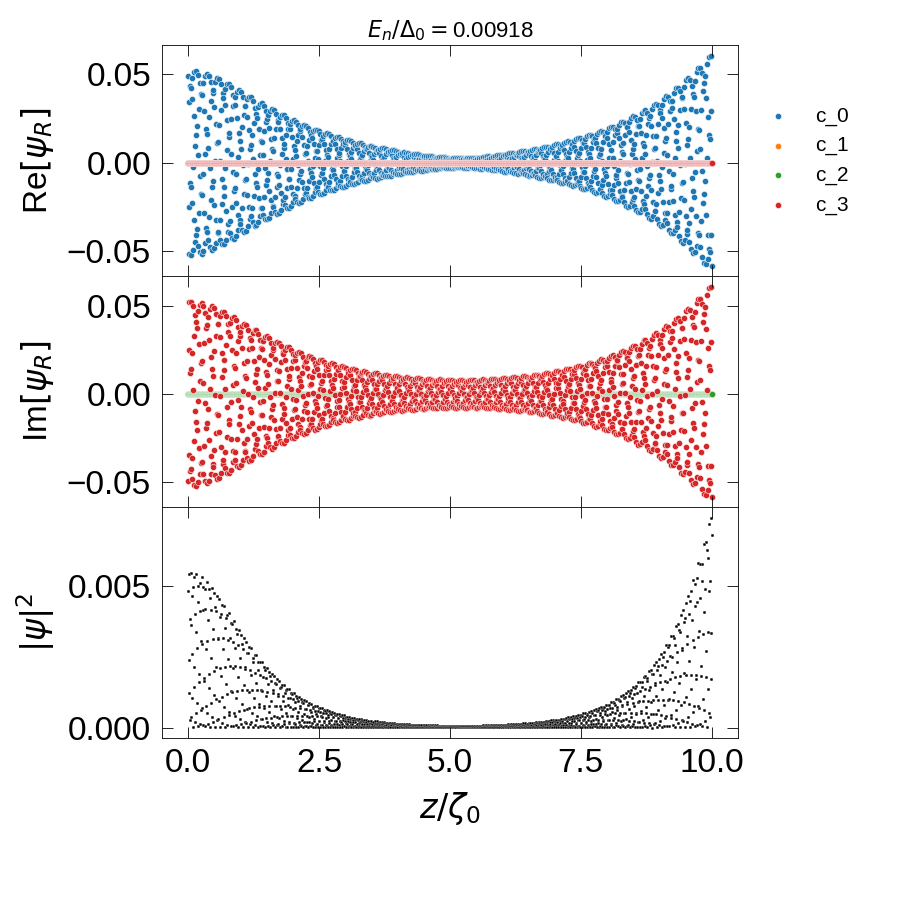

In [9]:
i = 1

data = psi_df.loc[:, i]

fig, ax = plt.subplots(3, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
for col in data.columns:
    if i>0: title = pos_E[(i-1)]
    else: title = np.flip(neg_E)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.scatterplot(x=data.index, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], s = 20, label = col)
    sns.scatterplot(x=data.index, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], s =20)
    sns.scatterplot(pdf.loc[:, i], color = 'k')

    ax[2].set_xlabel(r'$z/\zeta_0$')

    ax[0].set_ylabel(r'Re$[{\psi_R}]$')
    ax[1].set_ylabel(r'Im$[{\psi_R}]$')
    ax[2].set_ylabel(r'$|{\psi}|^2$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

# for a in ax:
    # a.set_xlim(0, 3)

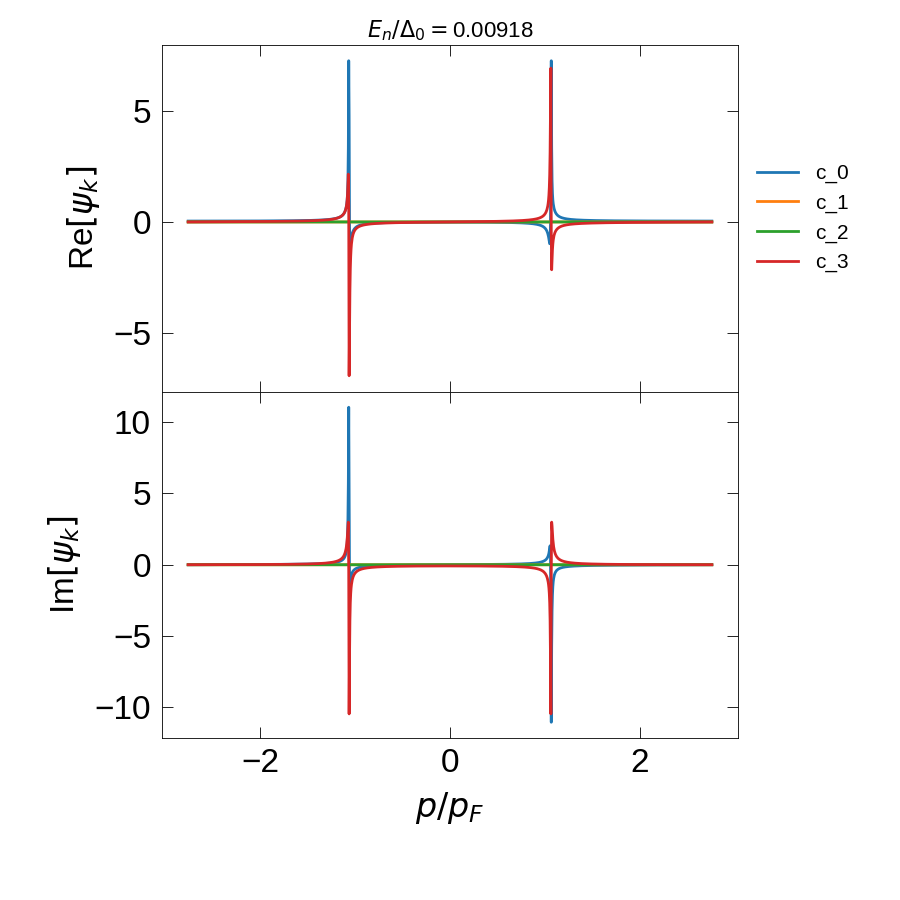

In [10]:
fig, ax = plt.subplots(2, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
data = psi_fft.loc[:, i]

for col in data.columns:
    
    if i>0: title = pos_E[(i-1)]
    else: title = np.flip(neg_E)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.lineplot(x=p, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], label = col)
    sns.lineplot(x=p, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], )

    ax[1].set_xlabel(r'$p/p_F$')
    ax[0].set_ylabel(r'Re$[{\psi_k}]$')
    ax[1].set_ylabel(r'Im$[{\psi_k}]$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)


(-1.1, 1.1)

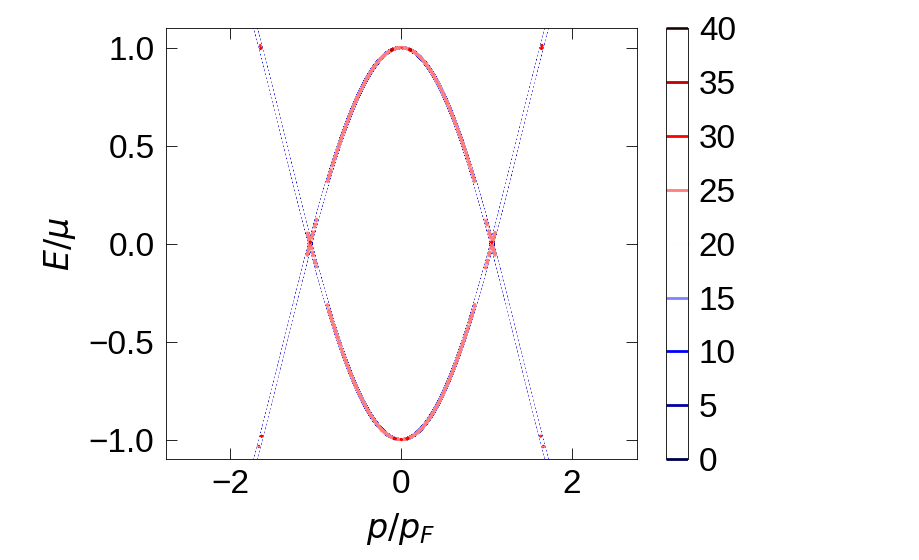

In [11]:
fig, ax = plt.subplots()
contour = ax.contour(p, eigval/kappa, psi_modes.T, cmap = 'seismic')
cbar = fig.colorbar(contour)
ax.set_xlabel(r'$p/p_F$')
ax.set_ylabel(r'$E/\mu$')

# ax.axhline(kappa, color='k')
ax.set_ylim(-1.1, 1.1)
    

# Andreev equation

In [12]:
# P = 29.3

# channel_height = 1.1E-6
# coherence_length = he3.v_Fermi(P)*he3.hbar/(2*np.pi*he3.kb*he3.Tc_line(P)*1E-3)

# z_real = np.linspace(0, 15, 2000)
# dz = z[1]-z[0]

# dz = 1E-2
# zmin = 0
# zmax = 10
# # z_real = np.arange(zmin, zmax+dz, dz)
# # z = z_real
# # z = z_real/z_real.max()*channel_height/coherence_length

# gap_spatial_dep = np.tanh(z*10)
# gap_spatial_dep = gap_spatial_perp(z, l = z.max()-z.min(), strech= 1)
# # gap_spatial_dep = np.tanh(z)
# tanh_mat = np.zeros((len(z), len(z)))
# np.fill_diagonal(tanh_mat, gap_spatial_dep)

# fig, ax = plt.subplots()
# ax.plot(z, gap_spatial_dep, 'o-', markersize = 4)

# ax.set_xlabel(r'$z/\zeta_0$')
# ax.set_ylabel(r'$\Delta_\perp/\Delta_0$')

# gam = 1.76

# energy_scale = he3.Tc_line(P)*1E-3/he3.T_Fermi(P) #Tc/Tf
# alpha = np.pi**2/gam *  energy_scale
# beta= np.pi/(1j)*energy_scale
# kappa = energy_scale**-1/gam #Tf/Tc



In [13]:
P = 29.3
gam = 1.76


dz = 0.75E-2
zmin = 0
zmax = 10
z = cp.arange(zmin, zmax+dz, dz)

gap_spatial_dep = np.tanh(z)
tanh_mat = cp.zeros((len(z), len(z)))
cp.fill_diagonal(tanh_mat, gap_spatial_dep)

energy_scale = he3.Tc_line(P)*1E-3/he3.T_Fermi(P) #Tc/Tf
alpha = np.pi**2/gam *  energy_scale
beta= np.pi/(1j)*energy_scale
kappa = energy_scale**-1/gam #Tf/Tc


K = -1*alpha*d2dx2_cuda(len(z), dz) - kappa*cp.identity(n = len(z))
U = beta * cp.matmul(tanh_mat, ddx_cuda(len(z), dz))

mat0 = cp.zeros((len(z), len(z)))

T = ddx_cuda(len(z), dz)*2*np.pi/gam
V = np.matmul(tanh_mat, ddx_cuda(len(z), dz))*np.pi/1j * energy_scale

# mat0 = np.zeros((len(z), len(z)))
H_andreev = cp.concatenate((
    cp.concatenate([T, mat0, mat0, V], axis = 1),
    cp.concatenate([mat0, T, V, mat0], axis = 1),
    cp.concatenate([mat0, cp.conjugate(V).T, -1*T, mat0], axis = 1),
    cp.concatenate([cp.conjugate(V), mat0, mat0, -T], axis = 1)
))

cp_andreev_eigval, cp_andreev_eigvec = cp.linalg.eigh(H_andreev)



In [14]:
andreev_eigval, andreev_eigvec = cp.asnumpy(cp_andreev_eigval), cp.asnumpy(cp_andreev_eigvec)
z = cp.asnumpy(z)
del cp_andreev_eigval, cp_andreev_eigvec, H_andreev, K, U, mat0, T, V, tanh_mat
cp.cuda.Device().synchronize()
cp.get_default_memory_pool().free_all_blocks()

E_a = andreev_eigval
pos_Ea = E_a[E_a>0]
neg_Ea = E_a[E_a<0]
psi_a_df = psi(andreev_eigvec, E_a, z)

In [15]:
pdf_a =psi_a_df.T.groupby('En', group_keys=False).apply(
    lambda x: (np.sum(np.abs(x)*np.abs(x), axis = 0))).T

psi_a_fft = psi_a_df.T.groupby('En', group_keys=False).apply(pandas_fft).T

k_a = np.fft.fftfreq(len(psi_a_fft))*len(psi_a_fft)/((z.max()-z.min()))*(2*np.pi)
p_a = k_a*(np.pi * energy_scale)
psi_a_fft.set_index(k_a, inplace = True)
psi_a_fft.index.name = 'k'

psi_a_modes = psi_a_fft.T.groupby('En', group_keys =False).apply(
    lambda x: np.sum(np.abs(x), axis =0)).T

(-1.1, 1.0)

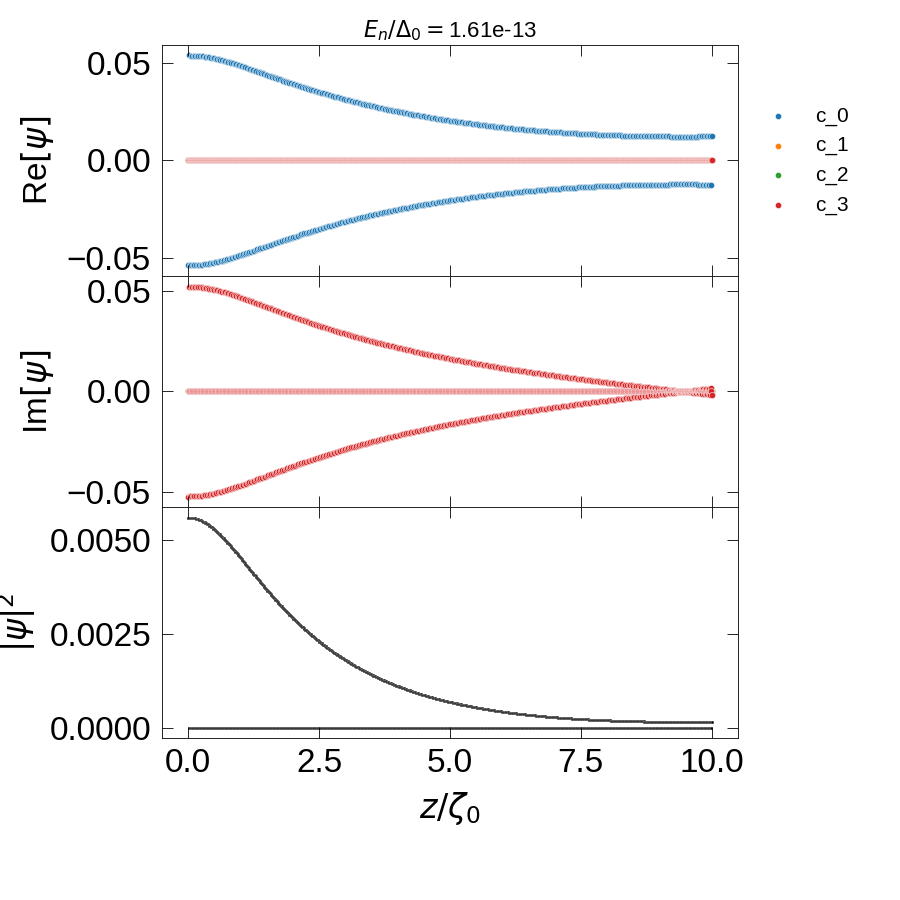

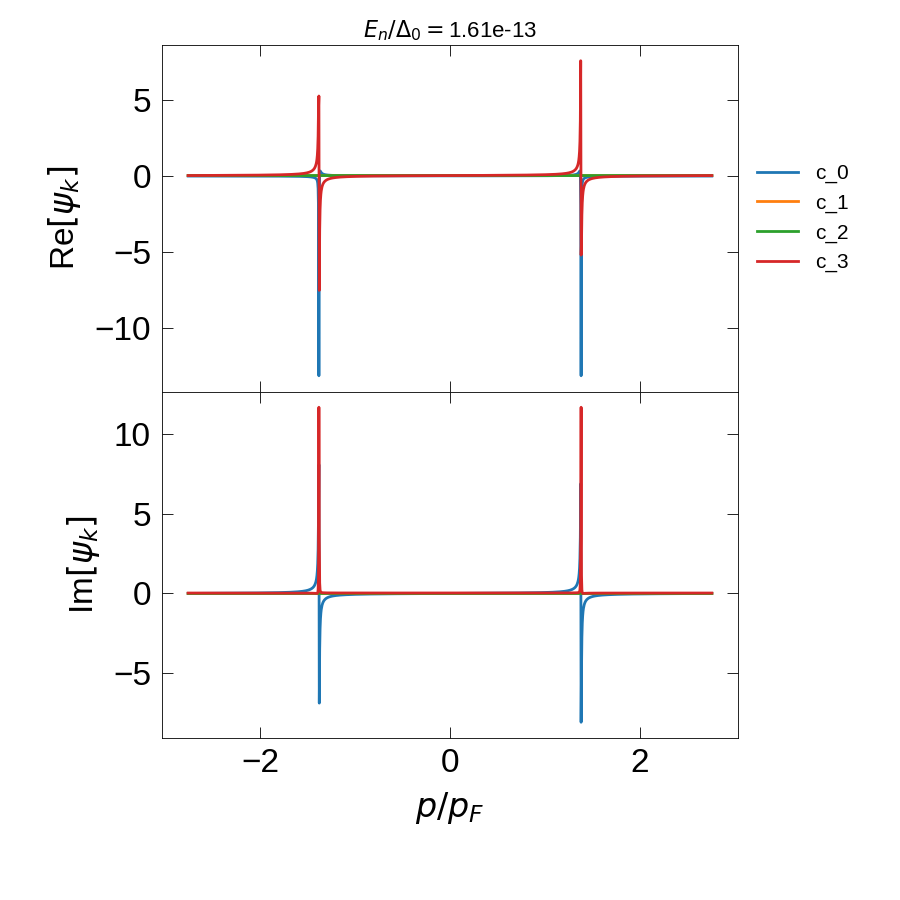

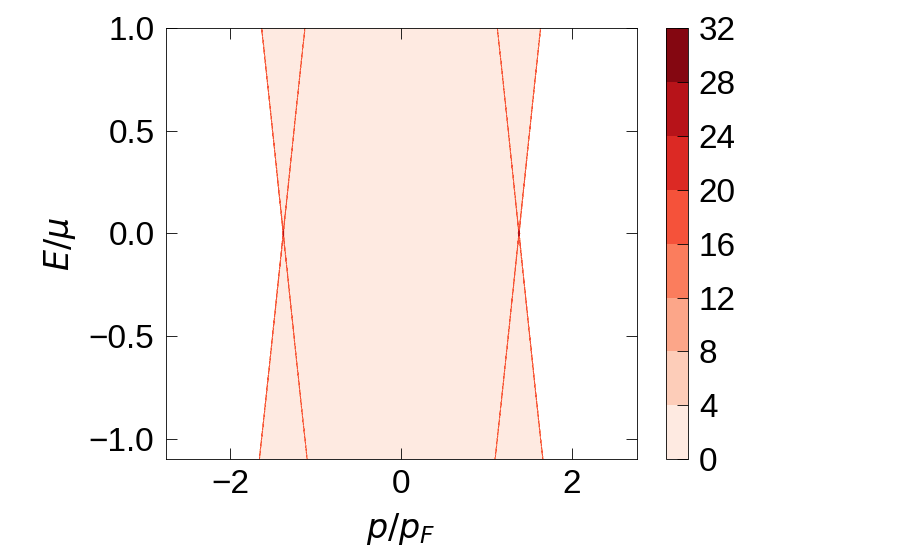

In [20]:
i =1

data = psi_a_df.loc[:, i]

fig, ax = plt.subplots(3, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
for col in data.columns:
    if i>0: title = pos_Ea[(i-1)]
    else: title = np.flip(neg_Ea)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.scatterplot(x=data.index, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], s = 20, label = col)
    sns.scatterplot(x=data.index, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], s =20)
    sns.scatterplot(pdf_a.loc[:, i], color = 'k')

    ax[2].set_xlabel(r'$z/\zeta_0$')

    ax[0].set_ylabel(r'Re$[{\psi}]$')
    ax[1].set_ylabel(r'Im$[{\psi}]$')
    ax[2].set_ylabel(r'$|{\psi}|^2$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)



fig, ax = plt.subplots(2, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
data = psi_a_fft.loc[:, i]

for col in data.columns:
    
    if i>0: title = pos_Ea[(i-1)]
    else: title = np.flip(neg_Ea)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.lineplot(x=p_a, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], label = col)
    sns.lineplot(x=p_a, y=-np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], )

    ax[1].set_xlabel(r'$p/p_F$')
    ax[0].set_ylabel(r'Re$[{\psi_k}]$')
    ax[1].set_ylabel(r'Im$[{\psi_k}]$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

fig, ax = plt.subplots()
# contour =ax.contourf(p_a, eigval_a, psi_a_modes.T, cmap = 'Reds')
contour =ax.contourf(p_a, E_a/kappa, psi_a_modes.T, cmap = 'Reds')

cbar = fig.colorbar(contour)
ax.set_xlabel(r'$p/p_F$')
ax.set_ylabel(r'$E/\mu$')
ax.set_ylim(-1.1, 1)
# ax.axvline(0.16, color = 'k', linestyle = '--', linewidth = 1)
# ax.axvline(0.17, color = 'k', linestyle = '--', linewidth = 1)
    